# Full-Dataset SMV SVM Pipeline (PyTorch, No sklearn)

This notebook now runs on the full local dataset inventory (all MUSAN files), not capped file subsets.

Implemented end-to-end:
- SMV-like 6-feature extraction and persistent feature cache
- RBF SVM from scratch in PyTorch (dual optimization)
- Filtering, skipping, and combined mechanisms
- Full metrics/analysis on all test files: confusion, precision/recall/F1, per-file stats, threshold/skip sweeps

## Notes
- Training uses all training files but samples a balanced reservoir of frames for tractable exact-kernel SVM training.
- Evaluation is run over all frames in all test files (speech/music), with optional noise analysis.
- No sklearn is used.

In [29]:

import math
import random
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torchaudio

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 220)


In [30]:

# ===== Configuration =====
DATA_ROOT = Path('musan')
CACHE_ROOT = Path('artifacts/full_feature_cache')
PRED_CACHE_ROOT = Path('artifacts/full_pred_cache')
OVERWRITE_FEATURE_CACHE = False
OVERWRITE_PRED_CACHE = True

SR = 8000
FRAME_SEC = 0.02
FRAME_SIZE = int(SR * FRAME_SEC)

TRAIN_RATIO = 0.8
INCLUDE_NOISE_ANALYSIS = True

# Reservoir size controls exact dual SVM memory/compute.
# All training files are traversed; reservoir frames are sampled proportionally across files.
RESERVOIR_PER_CLASS = 4000

# Exact-kernel RBF SVM (from scratch)
SVM_C = 2.0
SVM_GAMMA = 0.01
SVM_LR = 0.01
SVM_MAX_ITER = 700
SVM_TOL = 1e-5
MAX_SUPPORT_VECTORS = 1200   # inference acceleration after training

# Filtering / skipping default params (paper-style)
FILTERING_PARAMS = dict(eta_M=80.0, op='OR', eta_pr=6.0)
SKIPPING_PARAMS = dict(skip_len=15, N=1, eta_speech=1, eta_music=1)
COMBINED_PARAMS = dict(eta_M=80.0, op='OR', eta_pr=6.0, skip_len=16, N=1, eta_speech=1, eta_music=1)

# Batch for baseline inference over support vectors
INFER_BATCH = 512


## 1) Fast SMV-Like Feature Extraction + Cache

In [31]:

def audio_rel_stem(path: Path, root: Path) -> str:
    rel = path.relative_to(root)
    return str(rel.with_suffix('')).replace('/', '__')


def feature_cache_path(path: Path, root: Path = DATA_ROOT, cache_root: Path = CACHE_ROOT) -> Path:
    return cache_root / (audio_rel_stem(path, root) + '.npy')


def load_resample_mono(path: Path, target_sr: int = SR) -> np.ndarray:
    wav, sr = torchaudio.load(str(path))
    wav = wav.mean(dim=0)
    if sr != target_sr:
        wav = torchaudio.functional.resample(wav, sr, target_sr)
    x = wav.numpy().astype(np.float32)
    x = x / (np.max(np.abs(x)) + 1e-8)
    return x


def extract_smv_like_features_fast(wav: np.ndarray) -> np.ndarray:
    """
    Efficient SMV-like proxy features (6 dims):
      1) running avg log-energy
      2) running mean corr-based reflection proxy
      3) running mean residual-energy proxy
      4) running mean normalized pitch correlation proxy
      5) running avg periodicity counter c_pr
      6) running avg music continuity counter c_M
    """
    n = len(wav) // FRAME_SIZE
    if n <= 0:
        return np.zeros((0, 6), dtype=np.float32)

    frames = wav[: n * FRAME_SIZE].reshape(n, FRAME_SIZE)
    frames = frames * np.hamming(FRAME_SIZE).astype(np.float32)

    r0 = np.sum(frames * frames, axis=1) + 1e-8
    r1 = np.sum(frames[:, :-1] * frames[:, 1:], axis=1)
    r2 = np.sum(frames[:, :-2] * frames[:, 2:], axis=1)
    r3 = np.sum(frames[:, :-3] * frames[:, 3:], axis=1)

    rc = np.stack([r1 / r0, r2 / r0, r3 / r0], axis=1)
    rc_mean = np.mean(np.abs(rc), axis=1)
    residual_ratio = np.clip(1.0 - np.sum(rc * rc, axis=1) / 3.0, 0.0, 1.0)
    energy = np.mean(frames * frames, axis=1)

    # Pitch-correlation proxy: max normalized autocorrelation over lag range
    x = frames - frames.mean(axis=1, keepdims=True)
    npc = np.zeros((n,), dtype=np.float32)
    for lag in range(20, 81):
        x1 = x[:, :-lag]
        x2 = x[:, lag:]
        num = np.sum(x1 * x2, axis=1)
        den = np.sqrt(np.sum(x1 * x1, axis=1) * np.sum(x2 * x2, axis=1) + 1e-8)
        npc = np.maximum(npc, num / den)

    alpha = 0.9
    delta = 0.9

    out = np.zeros((n, 6), dtype=np.float32)

    cpr_counter = 0.0
    cpr_run = 0.0
    cm_counter = 0.0
    cm_run = 0.0

    r_energy = 0.0
    r_rc = 0.0
    r_res = 0.0
    r_npc = 0.0

    for t in range(n):
        music_like = (rc_mean[t] > 0.22 and npc[t] < 0.94) or (residual_ratio[t] < 0.60 and npc[t] < 0.97)

        if (t % 32) == 0:
            cpr_counter = 0.0
        cpr_counter += 1.0 if music_like else 0.0
        cpr_run = delta * cpr_run + (1.0 - delta) * cpr_counter

        if music_like:
            cm_counter = min(255.0, cm_counter + 2.0)
        else:
            cm_counter = max(0.0, cm_counter - 1.0)
        cm_run = 0.9 * cm_run + 0.1 * cm_counter

        r_energy = alpha * r_energy + (1.0 - alpha) * np.log1p(1000.0 * energy[t])
        r_rc = alpha * r_rc + (1.0 - alpha) * rc_mean[t]
        r_res = alpha * r_res + (1.0 - alpha) * residual_ratio[t]
        r_npc = alpha * r_npc + (1.0 - alpha) * npc[t]

        out[t] = [r_energy, r_rc, r_res, r_npc, cpr_run, cm_run]

    return out


def ensure_feature_cache_for_files(files: List[Path], label_name: str, overwrite: bool = False) -> List[dict]:
    CACHE_ROOT.mkdir(parents=True, exist_ok=True)
    rows = []
    t0 = time.perf_counter()

    for i, p in enumerate(files, start=1):
        cpath = feature_cache_path(p)
        if overwrite or (not cpath.exists()):
            wav = load_resample_mono(p)
            feat = extract_smv_like_features_fast(wav)
            cpath.parent.mkdir(parents=True, exist_ok=True)
            np.save(cpath, feat)
        else:
            feat = np.load(cpath, mmap_mode='r')

        rows.append({
            'path': str(p),
            'label_name': label_name,
            'cache_path': str(cpath),
            'n_frames': int(feat.shape[0]),
            'duration_sec': float(feat.shape[0] * FRAME_SEC),
        })

        if (i % 100) == 0:
            print(f'[{label_name}] processed {i}/{len(files)} files in {time.perf_counter()-t0:.1f}s')

    print(f'[{label_name}] done {len(files)} files in {time.perf_counter()-t0:.1f}s')
    return rows


## 2) Build Full File Index + Cache All Files

In [32]:

assert DATA_ROOT.exists(), f'{DATA_ROOT} not found'

speech_files = sorted((DATA_ROOT / 'speech').rglob('*.wav'))
music_files = sorted((DATA_ROOT / 'music').rglob('*.wav'))
noise_files = sorted((DATA_ROOT / 'noise').rglob('*.wav'))

print('speech files:', len(speech_files))
print('music files :', len(music_files))
print('noise files :', len(noise_files))

rows = []
rows += ensure_feature_cache_for_files(speech_files, 'speech', overwrite=OVERWRITE_FEATURE_CACHE)
rows += ensure_feature_cache_for_files(music_files, 'music', overwrite=OVERWRITE_FEATURE_CACHE)
if INCLUDE_NOISE_ANALYSIS:
    rows += ensure_feature_cache_for_files(noise_files, 'noise', overwrite=OVERWRITE_FEATURE_CACHE)

index_df = pd.DataFrame(rows)
index_df['label'] = index_df['label_name'].map({'speech': 1, 'music': -1, 'noise': 0})
index_df


speech files: 426
music files : 660
noise files : 930
[speech] processed 100/426 files in 0.0s
[speech] processed 200/426 files in 0.0s
[speech] processed 300/426 files in 0.0s
[speech] processed 400/426 files in 0.0s
[speech] done 426 files in 0.0s
[music] processed 100/660 files in 0.0s
[music] processed 200/660 files in 0.0s
[music] processed 300/660 files in 0.0s
[music] processed 400/660 files in 0.0s
[music] processed 500/660 files in 0.0s
[music] processed 600/660 files in 0.0s
[music] done 660 files in 0.0s
[noise] processed 100/930 files in 0.0s
[noise] processed 200/930 files in 0.0s
[noise] processed 300/930 files in 0.0s
[noise] processed 400/930 files in 0.0s
[noise] processed 500/930 files in 0.0s
[noise] processed 600/930 files in 0.0s
[noise] processed 700/930 files in 0.0s
[noise] processed 800/930 files in 0.0s
[noise] processed 900/930 files in 0.1s
[noise] done 930 files in 0.1s


,path,label_name,cache_path,n_frames,duration_sec,label
0,musan/speech/librivox/speech-librivox-0000.wav,speech,artifacts/full_feature_cache/speech__librivox_...,22201,444.02,1
1,musan/speech/librivox/speech-librivox-0001.wav,speech,artifacts/full_feature_cache/speech__librivox_...,3996,79.92,1
2,musan/speech/librivox/speech-librivox-0002.wav,speech,artifacts/full_feature_cache/speech__librivox_...,12686,253.72,1
3,musan/speech/librivox/speech-librivox-0003.wav,speech,artifacts/full_feature_cache/speech__librivox_...,11728,234.56,1
4,musan/speech/librivox/speech-librivox-0004.wav,speech,artifacts/full_feature_cache/speech__librivox_...,10702,214.04,1
...,...,...,...,...,...,...
2011,musan/noise/sound-bible/noise-sound-bible-0082...,noise,artifacts/full_feature_cache/noise__sound-bibl...,180,3.60,0
2012,musan/noise/sound-bible/noise-sound-bible-0083...,noise,artifacts/full_feature_cache/noise__sound-bibl...,2930,58.60,0
2013,musan/noise/sound-bible/noise-sound-bible-0084...,noise,artifacts/full_feature_cache/noise__sound-bibl...,402,8.04,0
2014,musan/noise/sound-bible/noise-sound-bible-0085...,noise,artifacts/full_feature_cache/noise__sound-bibl...,103,2.06,0


In [33]:

index_summary = (
    index_df
    .groupby('label_name', as_index=False)
    .agg(
        files=('path', 'count'),
        total_frames=('n_frames', 'sum'),
        total_hours=('duration_sec', lambda x: float(np.sum(x) / 3600.0)),
        mean_file_sec=('duration_sec', 'mean'),
        median_file_sec=('duration_sec', 'median'),
    )
)
index_summary


,label_name,files,total_frames,total_hours,mean_file_sec,median_file_sec
0,music,660,7670328,42.612933,232.434182,216.41
1,noise,930,1120322,6.224011,24.092946,11.13
2,speech,426,10880567,60.447594,510.824742,599.94


## 3) File-Level Train/Test Split (Speech/Music)

In [34]:

def split_paths(paths: List[str], train_ratio: float, seed: int) -> Tuple[List[str], List[str]]:
    rng = random.Random(seed)
    p = list(paths)
    rng.shuffle(p)
    n = int(len(p) * train_ratio)
    return p[:n], p[n:]

speech_paths = index_df[index_df.label_name == 'speech']['path'].tolist()
music_paths = index_df[index_df.label_name == 'music']['path'].tolist()

train_speech, test_speech = split_paths(speech_paths, TRAIN_RATIO, SEED)
train_music, test_music = split_paths(music_paths, TRAIN_RATIO, SEED + 1)

index_df['split'] = 'unused'
index_df.loc[index_df['path'].isin(train_speech + train_music), 'split'] = 'train'
index_df.loc[index_df['path'].isin(test_speech + test_music), 'split'] = 'test'
if INCLUDE_NOISE_ANALYSIS:
    index_df.loc[index_df['label_name'] == 'noise', 'split'] = 'noise_eval'

split_summary = (
    index_df[index_df['label_name'].isin(['speech', 'music'])]
    .groupby(['split', 'label_name'], as_index=False)
    .agg(files=('path', 'count'), frames=('n_frames', 'sum'), hours=('duration_sec', lambda x: float(np.sum(x) / 3600.0)))
)
split_summary


,split,label_name,files,frames,hours
0,test,music,132,1436752,7.981956
1,test,speech,86,2294052,12.744733
2,train,music,528,6233576,34.630978
3,train,speech,340,8586515,47.702861


## 4) Training Stats On Full Train Frames

In [35]:

train_df = index_df[index_df['split'] == 'train'].copy()

sum_vec = np.zeros(6, dtype=np.float64)
sumsq_vec = np.zeros(6, dtype=np.float64)
count_frames = 0

for i, row in enumerate(train_df.itertuples(index=False), start=1):
    x = np.load(row.cache_path)
    if x.shape[0] == 0:
        continue
    sum_vec += x.sum(axis=0)
    sumsq_vec += (x * x).sum(axis=0)
    count_frames += x.shape[0]

    if (i % 200) == 0:
        print(f'stats pass: {i}/{len(train_df)} files')

feat_mean = sum_vec / max(count_frames, 1)
feat_var = np.maximum(sumsq_vec / max(count_frames, 1) - feat_mean * feat_mean, 1e-8)
feat_std = np.sqrt(feat_var) + 1e-6

print('train frames used for stats:', count_frames)
print('feature mean:', np.round(feat_mean, 4))
print('feature std :', np.round(feat_std, 4))


stats pass: 200/868 files
stats pass: 400/868 files
stats pass: 600/868 files
stats pass: 800/868 files
train frames used for stats: 14820091
feature mean: [  1.3595   0.6759   0.468    0.422   16.0241 253.3922]
feature std : [ 1.0108  0.1667  0.1985  0.1365  3.7788 16.4435]


## 5) Reservoir Sampling From All Train Files

In [36]:

def proportional_reservoir_from_files(df: pd.DataFrame, per_class_target: int, seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    X_parts = []
    y_parts = []

    for cls in [1, -1]:
        cls_df = df[df['label'] == cls].copy()
        total_frames = int(cls_df['n_frames'].sum())

        # Allocate per-file sample quota proportional to frame count.
        quotas = []
        for row in cls_df.itertuples(index=False):
            q = int(round((row.n_frames / max(total_frames, 1)) * per_class_target))
            if row.n_frames > 0:
                q = max(1, q)
            else:
                q = 0
            quotas.append(q)

        # Adjust total quota to exactly target
        quota_sum = int(np.sum(quotas))
        diff = per_class_target - quota_sum
        order = np.argsort(-cls_df['n_frames'].values)
        k = 0
        while diff != 0 and len(order) > 0 and k < 100000:
            idx = int(order[k % len(order)])
            if diff > 0:
                quotas[idx] += 1
                diff -= 1
            else:
                if quotas[idx] > 1:
                    quotas[idx] -= 1
                    diff += 1
            k += 1

        cls_samples = []
        for q, row in zip(quotas, cls_df.itertuples(index=False)):
            if q <= 0:
                continue
            x = np.load(row.cache_path)
            if x.shape[0] == 0:
                continue
            q_eff = min(q, x.shape[0])
            idx = rng.choice(x.shape[0], size=q_eff, replace=False)
            cls_samples.append(x[idx])

        Xc = np.vstack(cls_samples) if cls_samples else np.zeros((0, 6), dtype=np.float32)

        # In case rounding overshot, clip down to target
        if Xc.shape[0] > per_class_target:
            idx = rng.choice(Xc.shape[0], size=per_class_target, replace=False)
            Xc = Xc[idx]

        # In case undershot, top up from largest files
        while Xc.shape[0] < per_class_target:
            for row in cls_df.sort_values('n_frames', ascending=False).itertuples(index=False):
                x = np.load(row.cache_path)
                if x.shape[0] == 0:
                    continue
                need = per_class_target - Xc.shape[0]
                q_eff = min(need, x.shape[0])
                idx = rng.choice(x.shape[0], size=q_eff, replace=False)
                add = x[idx]
                Xc = np.vstack([Xc, add]) if Xc.shape[0] else add
                if Xc.shape[0] >= per_class_target:
                    break

        yc = np.full((Xc.shape[0],), cls, dtype=np.int64)
        X_parts.append(Xc.astype(np.float32))
        y_parts.append(yc)

    X = np.vstack(X_parts)
    y = np.concatenate(y_parts)

    p = np.random.permutation(X.shape[0])
    return X[p], y[p]


X_train_raw, y_train = proportional_reservoir_from_files(train_df, per_class_target=RESERVOIR_PER_CLASS, seed=SEED)
X_train = (X_train_raw - feat_mean) / feat_std

print('X_train_raw shape:', X_train_raw.shape)
print('class counts:', {int(c): int(np.sum(y_train == c)) for c in np.unique(y_train)})


X_train_raw shape: (8000, 6)
class counts: {-1: 4000, 1: 4000}


## 6) PyTorch RBF SVM From Scratch

In [37]:

class TorchRBFSVM:
    def __init__(self, C=2.0, gamma=0.01, lr=0.01, max_iter=700, tol=1e-5, device='cpu'):
        self.C = C
        self.gamma = gamma
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.device = device

    def _rbf_kernel(self, X1: torch.Tensor, X2: torch.Tensor) -> torch.Tensor:
        x1_sq = (X1 * X1).sum(dim=1, keepdim=True)
        x2_sq = (X2 * X2).sum(dim=1).unsqueeze(0)
        dist2 = torch.clamp(x1_sq + x2_sq - 2.0 * (X1 @ X2.T), min=0.0)
        return torch.exp(-self.gamma * dist2)

    def fit(self, X: np.ndarray, y: np.ndarray):
        X_t = torch.tensor(X, dtype=torch.float32, device=self.device)
        y_t = torch.tensor(y, dtype=torch.float32, device=self.device)

        K = self._rbf_kernel(X_t, X_t)
        Q = (y_t[:, None] * y_t[None, :]) * K

        alpha = torch.zeros(X_t.shape[0], dtype=torch.float32, device=self.device)
        y_norm = torch.dot(y_t, y_t)
        prev_obj = -1e12

        for it in range(self.max_iter):
            grad = 1.0 - Q @ alpha
            alpha = alpha + self.lr * grad
            alpha = torch.clamp(alpha, 0.0, self.C)
            alpha = alpha - y_t * (torch.dot(y_t, alpha) / (y_norm + 1e-8))
            alpha = torch.clamp(alpha, 0.0, self.C)

            if (it % 25 == 0) or (it == self.max_iter - 1):
                obj = torch.sum(alpha) - 0.5 * torch.dot(alpha, Q @ alpha)
                if abs((obj - prev_obj).item()) < self.tol:
                    break
                prev_obj = obj

        sv_mask = alpha > 1e-5
        self.support_vectors = X_t[sv_mask].detach().cpu().numpy().astype(np.float32)
        self.support_labels = y_t[sv_mask].detach().cpu().numpy().astype(np.float32)
        self.alpha = alpha[sv_mask].detach().cpu().numpy().astype(np.float32)
        self.alpha_y = self.alpha * self.support_labels

        if self.support_vectors.shape[0] == 0:
            self.b = 0.0
            return

        margin_mask = (alpha > 1e-5) & (alpha < self.C - 1e-5)
        if torch.any(margin_mask):
            idx = torch.where(margin_mask)[0]
            if idx.numel() > 256:
                idx = idx[:256]
            b_vals = []
            for i in idx:
                k_col = K[sv_mask, i]
                fi = torch.sum(alpha[sv_mask] * y_t[sv_mask] * k_col)
                b_vals.append((y_t[i] - fi).item())
            self.b = float(np.mean(b_vals))
        else:
            dec = Q @ alpha
            self.b = float(torch.mean(y_t - dec).item())

    def prune_support_vectors(self, max_sv: int):
        if self.alpha.shape[0] <= max_sv:
            return
        keep = np.argpartition(np.abs(self.alpha), -max_sv)[-max_sv:]
        self.support_vectors = self.support_vectors[keep]
        self.support_labels = self.support_labels[keep]
        self.alpha = self.alpha[keep]
        self.alpha_y = self.alpha * self.support_labels

    def decision_function(self, X: np.ndarray, batch_size: int = 512) -> np.ndarray:
        if self.support_vectors.shape[0] == 0:
            return np.zeros((X.shape[0],), dtype=np.float32)

        sv = self.support_vectors
        ay = self.alpha_y
        out = np.zeros((X.shape[0],), dtype=np.float32)

        sv_sq = np.sum(sv * sv, axis=1)[None, :]
        for i in range(0, X.shape[0], batch_size):
            xb = X[i:i + batch_size]
            xb_sq = np.sum(xb * xb, axis=1, keepdims=True)
            dist2 = np.clip(xb_sq + sv_sq - 2.0 * (xb @ sv.T), a_min=0.0, a_max=None)
            K = np.exp(-self.gamma * dist2)
            out[i:i + batch_size] = K @ ay + self.b
        return out

    def predict(self, X: np.ndarray, batch_size: int = 512) -> np.ndarray:
        s = self.decision_function(X, batch_size=batch_size)
        return np.where(s >= 0.0, 1, -1).astype(np.int64)


In [38]:

svm = TorchRBFSVM(
    C=SVM_C,
    gamma=SVM_GAMMA,
    lr=SVM_LR,
    max_iter=SVM_MAX_ITER,
    tol=SVM_TOL,
    device='cpu',
)

t0 = time.perf_counter()
svm.fit(X_train, y_train)
train_sec = time.perf_counter() - t0

sv_before = svm.alpha.shape[0]
svm.prune_support_vectors(MAX_SUPPORT_VECTORS)
sv_after = svm.alpha.shape[0]

print(f'train_time_sec={train_sec:.2f}')
print('support_vectors_before_prune:', sv_before)
print('support_vectors_after_prune :', sv_after)


train_time_sec=3.37
support_vectors_before_prune: 6960
support_vectors_after_prune : 1200


## 7) Baseline Inference Cache On Full Test Set

In [39]:

def pred_cache_path_for_feature(cache_path: str, pred_root: Path = PRED_CACHE_ROOT) -> Path:
    cp = Path(cache_path)
    return pred_root / (cp.stem + '__baseline.npz')


def ensure_baseline_pred_cache(test_df: pd.DataFrame, model: TorchRBFSVM, feat_mean: np.ndarray, feat_std: np.ndarray,
                               overwrite: bool = True, batch_size: int = 512) -> Tuple[float, int]:
    PRED_CACHE_ROOT.mkdir(parents=True, exist_ok=True)

    total_time = 0.0
    total_frames = 0

    for i, row in enumerate(test_df.itertuples(index=False), start=1):
        out_path = pred_cache_path_for_feature(row.cache_path)

        if overwrite or (not out_path.exists()):
            raw = np.load(row.cache_path)
            Xn = (raw - feat_mean) / feat_std

            t0 = time.perf_counter()
            scores = model.decision_function(Xn, batch_size=batch_size)
            elapsed = time.perf_counter() - t0

            pred = np.where(scores >= 0.0, 1, -1).astype(np.int64)
            np.savez_compressed(out_path, pred=pred, score=scores.astype(np.float32))

            total_time += elapsed
            total_frames += raw.shape[0]
        else:
            raw = np.load(row.cache_path, mmap_mode='r')
            total_frames += raw.shape[0]

        if (i % 100) == 0:
            print(f'baseline cache: {i}/{len(test_df)} files')

    return total_time, total_frames


test_df = index_df[index_df['split'] == 'test'].copy().reset_index(drop=True)
baseline_infer_time, baseline_infer_frames = ensure_baseline_pred_cache(
    test_df=test_df,
    model=svm,
    feat_mean=feat_mean,
    feat_std=feat_std,
    overwrite=OVERWRITE_PRED_CACHE,
    batch_size=INFER_BATCH,
)

baseline_ms_per_frame = 1000.0 * baseline_infer_time / max(baseline_infer_frames, 1)
print('baseline inference frames:', baseline_infer_frames)
print(f'baseline measured ms/frame: {baseline_ms_per_frame:.6f}')


baseline cache: 100/218 files
baseline cache: 200/218 files
baseline inference frames: 3730804
baseline measured ms/frame: 0.010921


## 8) Metrics + Method Simulators

In [40]:

@dataclass
class BinaryAccumulator:
    tp: int = 0  # speech->speech
    tn: int = 0  # music->music
    fp: int = 0  # music->speech
    fn: int = 0  # speech->music

    def update(self, y_true: np.ndarray, y_pred: np.ndarray):
        self.tp += int(np.sum((y_true == 1) & (y_pred == 1)))
        self.fn += int(np.sum((y_true == 1) & (y_pred == -1)))
        self.tn += int(np.sum((y_true == -1) & (y_pred == -1)))
        self.fp += int(np.sum((y_true == -1) & (y_pred == 1)))

    def to_metrics(self) -> dict:
        tp, tn, fp, fn = self.tp, self.tn, self.fp, self.fn
        total = tp + tn + fp + fn

        acc = (tp + tn) / total if total else np.nan
        speech_recall = tp / (tp + fn) if (tp + fn) else np.nan
        music_recall = tn / (tn + fp) if (tn + fp) else np.nan

        speech_precision = tp / (tp + fp) if (tp + fp) else np.nan
        music_precision = tn / (tn + fn) if (tn + fn) else np.nan

        speech_f1 = 2 * speech_precision * speech_recall / (speech_precision + speech_recall) if (speech_precision + speech_recall) else np.nan
        music_f1 = 2 * music_precision * music_recall / (music_precision + music_recall) if (music_precision + music_recall) else np.nan

        bal_acc = (speech_recall + music_recall) / 2 if (not np.isnan(speech_recall) and not np.isnan(music_recall)) else np.nan

        return {
            'overall_acc': acc,
            'speech_precision': speech_precision,
            'speech_recall': speech_recall,
            'speech_f1': speech_f1,
            'music_precision': music_precision,
            'music_recall': music_recall,
            'music_f1': music_f1,
            'balanced_acc': bal_acc,
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'total_frames_eval': total,
        }


def filtering_mask(raw: np.ndarray, eta_M: float, op: str, eta_pr: float) -> np.ndarray:
    cond_M = raw[:, 5] > eta_M
    cond_pr = raw[:, 4] > eta_pr
    if op.upper() == 'AND':
        return cond_M & cond_pr
    return cond_M | cond_pr


def simulate_filtering(raw: np.ndarray, baseline_pred: np.ndarray, eta_M: float, op: str, eta_pr: float):
    mask = filtering_mask(raw, eta_M, op, eta_pr)
    pred = baseline_pred.copy()
    pred[mask] = -1

    info = {
        'filtered': int(np.sum(mask)),
        'skipped': 0,
        'svm_calls': int(len(baseline_pred) - np.sum(mask)),
    }
    return pred, info


def simulate_skipping(baseline_pred: np.ndarray, skip_len: int, N: int, eta_speech: int, eta_music: int):
    n = baseline_pred.shape[0]
    out = np.empty((n,), dtype=np.int64)

    hist = []
    nskip = 0
    cprev = 1
    skipped = 0
    svm_calls = 0

    for i in range(n):
        if nskip > 0:
            out[i] = cprev
            skipped += 1
            nskip -= 1
            hist.append(cprev)
            continue

        y = int(baseline_pred[i])
        out[i] = y
        svm_calls += 1
        hist.append(y)

        if len(hist) >= N:
            tail = hist[-N:]
            if tail.count(1) >= eta_speech:
                cprev = 1
                nskip = skip_len
            elif tail.count(-1) >= eta_music:
                cprev = -1
                nskip = skip_len

    info = {
        'filtered': 0,
        'skipped': skipped,
        'svm_calls': svm_calls,
    }
    return out, info


def simulate_combined(raw: np.ndarray, baseline_pred: np.ndarray, eta_M: float, op: str, eta_pr: float,
                      skip_len: int, N: int, eta_speech: int, eta_music: int):
    n = baseline_pred.shape[0]
    out = np.empty((n,), dtype=np.int64)

    hist = []
    nskip = 0
    cprev = 1

    filtered = 0
    skipped = 0
    svm_calls = 0

    mask = filtering_mask(raw, eta_M, op, eta_pr)

    for i in range(n):
        if mask[i]:
            out[i] = -1
            filtered += 1
            hist.append(-1)

            if nskip > 0:
                if cprev == 1:
                    nskip = 0
                else:
                    nskip = max(nskip - 1, 0)
            continue

        if nskip > 0:
            out[i] = cprev
            skipped += 1
            nskip -= 1
            hist.append(cprev)
            continue

        y = int(baseline_pred[i])
        out[i] = y
        svm_calls += 1
        hist.append(y)

        if len(hist) >= N:
            tail = hist[-N:]
            if tail.count(1) >= eta_speech:
                cprev = 1
                nskip = skip_len
            elif tail.count(-1) >= eta_music:
                cprev = -1
                nskip = skip_len

    info = {
        'filtered': filtered,
        'skipped': skipped,
        'svm_calls': svm_calls,
    }
    return out, info


## 9) Full-Test Evaluation (All Test Files)

In [41]:

def evaluate_method_on_test(method_name: str, test_df: pd.DataFrame, params: dict, baseline_ms_per_frame: float):
    acc = BinaryAccumulator()

    total_frames = 0
    total_filtered = 0
    total_skipped = 0
    total_svm_calls = 0

    per_file_rows = []

    for i, row in enumerate(test_df.itertuples(index=False), start=1):
        raw = np.load(row.cache_path)
        pred_pack = np.load(pred_cache_path_for_feature(row.cache_path))
        base_pred = pred_pack['pred']

        if row.label == 1:
            y_true = np.ones((raw.shape[0],), dtype=np.int64)
        elif row.label == -1:
            y_true = -np.ones((raw.shape[0],), dtype=np.int64)
        else:
            continue

        if method_name == 'Baseline':
            y_pred = base_pred
            info = {'filtered': 0, 'skipped': 0, 'svm_calls': int(len(base_pred))}
        elif method_name == 'Filtering':
            y_pred, info = simulate_filtering(raw, base_pred, **params)
        elif method_name == 'Skipping':
            y_pred, info = simulate_skipping(base_pred, **params)
        elif method_name == 'Combined':
            y_pred, info = simulate_combined(raw, base_pred, **params)
        else:
            raise ValueError(method_name)

        acc.update(y_true, y_pred)

        total_frames += len(y_true)
        total_filtered += info['filtered']
        total_skipped += info['skipped']
        total_svm_calls += info['svm_calls']

        # file-level accuracy for distribution analysis
        file_acc = float(np.mean(y_true == y_pred)) if len(y_true) else np.nan
        per_file_rows.append({
            'path': row.path,
            'label_name': row.label_name,
            'n_frames': len(y_true),
            'file_acc': file_acc,
            'filtered_ratio_file': info['filtered'] / max(len(y_true), 1),
            'skipped_ratio_file': info['skipped'] / max(len(y_true), 1),
            'svm_call_ratio_file': info['svm_calls'] / max(len(y_true), 1),
        })

        if (i % 100) == 0:
            print(f'{method_name}: {i}/{len(test_df)} files')

    m = acc.to_metrics()
    m.update({
        'method': method_name,
        'filtered_ratio': total_filtered / max(total_frames, 1),
        'skipped_ratio': total_skipped / max(total_frames, 1),
        'overall_ratio': (total_filtered + total_skipped) / max(total_frames, 1),
        'svm_call_ratio': total_svm_calls / max(total_frames, 1),
        'estimated_time_ms_per_frame': baseline_ms_per_frame * (total_svm_calls / max(total_frames, 1)),
    })

    per_file_df = pd.DataFrame(per_file_rows)
    return m, per_file_df


method_specs = {
    'Baseline': {},
    'Filtering': FILTERING_PARAMS,
    'Skipping': SKIPPING_PARAMS,
    'Combined': COMBINED_PARAMS,
}

summary_rows = []
per_file_map = {}
for name, p in method_specs.items():
    row, per_file_df = evaluate_method_on_test(name, test_df, p, baseline_ms_per_frame)
    summary_rows.append(row)
    per_file_map[name] = per_file_df

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df[[
    'method',
    'overall_acc', 'balanced_acc',
    'speech_precision', 'speech_recall', 'speech_f1',
    'music_precision', 'music_recall', 'music_f1',
    'filtered_ratio', 'skipped_ratio', 'overall_ratio', 'svm_call_ratio',
    'estimated_time_ms_per_frame',
    'tp', 'tn', 'fp', 'fn', 'total_frames_eval'
]].sort_values('overall_acc', ascending=False)

summary_df


Baseline: 100/218 files
Baseline: 200/218 files
Filtering: 100/218 files
Filtering: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Combined: 100/218 files
Combined: 200/218 files


,method,overall_acc,balanced_acc,speech_precision,speech_recall,speech_f1,music_precision,music_recall,music_f1,filtered_ratio,skipped_ratio,overall_ratio,svm_call_ratio,estimated_time_ms_per_frame,tp,tn,fp,fn,total_frames_eval
1,Filtering,0.385274,0.499726,0.545311,0.001655,0.003300,0.384975,0.997796,0.555590,0.998134,0.000000,0.998134,0.001866,0.000020,3797,1433586,3166,2290255,3730804
3,Combined,0.385274,0.499726,0.545311,0.001655,0.003300,0.384975,0.997796,0.555590,0.998134,0.001738,0.999871,0.000129,0.000001,3797,1433586,3166,2290255,3730804
0,Baseline,0.384852,0.498844,0.465368,0.002771,0.005508,0.384556,0.994918,0.554706,0.000000,0.000000,0.000000,1.000000,0.010921,6356,1429450,7302,2287696,3730804
2,Skipping,0.384812,0.498724,0.463185,0.003000,0.005961,0.384499,0.994449,0.554574,0.000000,0.937477,0.937477,0.062523,0.000683,6882,1428776,7976,2287170,3730804


## 10) Per-File Distribution Analysis

In [42]:

rows = []
for method, dfm in per_file_map.items():
    for cls in ['speech', 'music']:
        d = dfm[dfm['label_name'] == cls]
        rows.append({
            'method': method,
            'class': cls,
            'files': len(d),
            'mean_file_acc': float(d['file_acc'].mean()),
            'std_file_acc': float(d['file_acc'].std(ddof=0)),
            'min_file_acc': float(d['file_acc'].min()),
            'max_file_acc': float(d['file_acc'].max()),
            'mean_filtered_ratio_file': float(d['filtered_ratio_file'].mean()),
            'mean_skipped_ratio_file': float(d['skipped_ratio_file'].mean()),
        })

per_file_summary = pd.DataFrame(rows).sort_values(['method', 'class'])
per_file_summary


,method,class,files,mean_file_acc,std_file_acc,min_file_acc,max_file_acc,mean_filtered_ratio_file,mean_skipped_ratio_file
1,Baseline,music,132,0.993828,0.006932,0.929850,0.998748,0.000000,0.000000
0,Baseline,speech,86,0.003845,0.006685,0.001034,0.039674,0.000000,0.000000
7,Combined,music,132,0.997197,0.005975,0.939243,0.999542,0.997197,0.002604
6,Combined,speech,86,0.002173,0.004659,0.000315,0.024945,0.997827,0.002027
3,Filtering,music,132,0.997197,0.005975,0.939243,0.999542,0.997197,0.000000
2,Filtering,speech,86,0.002173,0.004659,0.000315,0.024945,0.997827,0.000000
5,Skipping,music,132,0.993270,0.007039,0.929557,0.998535,0.000000,0.937453
4,Skipping,speech,86,0.004220,0.007349,0.001079,0.048830,0.000000,0.937475


## 11) Filtering Threshold Sweep (Full Test Set)

In [43]:

triplets = [
    (80, 'AND', 4),
    (70, 'AND', 2),
    (80, 'OR', 6),
    (60, 'OR', 4),
    (40, 'OR', 2),
    (30, 'AND', 1),
]

rows = []
for eta_M, op, eta_pr in triplets:
    params = dict(eta_M=float(eta_M), op=op, eta_pr=float(eta_pr))
    r, _ = evaluate_method_on_test('Filtering', test_df, params, baseline_ms_per_frame)
    rows.append({
        'triplet': f'{{{eta_M}, {op}, {eta_pr}}}',
        'overall_acc': r['overall_acc'],
        'speech_recall': r['speech_recall'],
        'music_recall': r['music_recall'],
        'speech_f1': r['speech_f1'],
        'music_f1': r['music_f1'],
        'filtered_ratio': r['filtered_ratio'],
        'svm_call_ratio': r['svm_call_ratio'],
        'estimated_time_ms_per_frame': r['estimated_time_ms_per_frame'],
    })

filtering_sweep_df = pd.DataFrame(rows).sort_values('filtered_ratio', ascending=False)
filtering_sweep_df


Filtering: 100/218 files
Filtering: 200/218 files
Filtering: 100/218 files
Filtering: 200/218 files
Filtering: 100/218 files
Filtering: 200/218 files
Filtering: 100/218 files
Filtering: 200/218 files
Filtering: 100/218 files
Filtering: 200/218 files
Filtering: 100/218 files
Filtering: 200/218 files


,triplet,overall_acc,speech_recall,music_recall,speech_f1,music_f1,filtered_ratio,svm_call_ratio,estimated_time_ms_per_frame
4,"{40, OR, 2}",0.385249,0.001106,0.998609,0.002207,0.555781,0.998784,0.001216,0.000013
3,"{60, OR, 4}",0.385275,0.001389,0.998222,0.002771,0.555695,0.998461,0.001539,0.000017
2,"{80, OR, 6}",0.385274,0.001655,0.997796,0.003300,0.555590,0.998134,0.001866,0.000020
5,"{30, AND, 1}",0.385135,0.002096,0.996729,0.004175,0.555269,0.995823,0.004177,0.000046
1,"{70, AND, 2}",0.384866,0.002768,0.994958,0.005504,0.554722,0.994255,0.005745,0.000063
0,"{80, AND, 4}",0.384852,0.002771,0.994918,0.005508,0.554706,0.993493,0.006507,0.000071


## 12) Skipping Parameter Sweep (Full Test Set)

In [44]:

skip_lengths = [4, 8, 16, 32]
N_values = [1, 4, 16]

rows = []
for s in skip_lengths:
    for N in N_values:
        params = dict(skip_len=s, N=N, eta_speech=N, eta_music=N)
        r, _ = evaluate_method_on_test('Skipping', test_df, params, baseline_ms_per_frame)
        rows.append({
            'skip_len': s,
            'N': N,
            'overall_acc': r['overall_acc'],
            'speech_recall': r['speech_recall'],
            'music_recall': r['music_recall'],
            'overall_ratio': r['overall_ratio'],
            'svm_call_ratio': r['svm_call_ratio'],
            'estimated_time_ms_per_frame': r['estimated_time_ms_per_frame'],
        })

skipping_sweep_df = pd.DataFrame(rows).sort_values(['overall_acc', 'overall_ratio'], ascending=[False, False])
skipping_sweep_df


Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files
Skipping: 100/218 files
Skipping: 200/218 files


,skip_len,N,overall_acc,speech_recall,music_recall,overall_ratio,svm_call_ratio,estimated_time_ms_per_frame
1,4,4,0.384826,0.002850,0.994726,0.799683,0.200317,0.002188
4,8,4,0.384816,0.002924,0.994579,0.888537,0.111463,0.001217
0,4,1,0.384816,0.002827,0.994734,0.799978,0.200022,0.002184
2,4,16,0.384816,0.002827,0.994734,0.798509,0.201491,0.002200
3,8,1,0.384797,0.002907,0.994559,0.888864,0.111136,0.001214
8,16,16,0.384792,0.003017,0.994369,0.939424,0.060576,0.000662
6,16,1,0.384779,0.003058,0.994270,0.941150,0.058850,0.000643
5,8,16,0.384771,0.002859,0.994569,0.887233,0.112767,0.001232
11,32,16,0.384749,0.003057,0.994193,0.967893,0.032107,0.000351
7,16,4,0.384744,0.003127,0.994070,0.940802,0.059198,0.000646


## 13) Optional Noise-Only Behavior Analysis

In [45]:

if INCLUDE_NOISE_ANALYSIS:
    noise_df = index_df[index_df['split'] == 'noise_eval'].copy().reset_index(drop=True)

    # Baseline prediction cache for noise
    _time, _frames = ensure_baseline_pred_cache(
        test_df=noise_df,
        model=svm,
        feat_mean=feat_mean,
        feat_std=feat_std,
        overwrite=OVERWRITE_PRED_CACHE,
        batch_size=INFER_BATCH,
    )

    def noise_stats_for_method(method_name: str, params: dict):
        total = 0
        pred_speech = 0
        pred_music = 0

        for row in noise_df.itertuples(index=False):
            raw = np.load(row.cache_path)
            base_pred = np.load(pred_cache_path_for_feature(row.cache_path))['pred']

            if method_name == 'Baseline':
                pred = base_pred
            elif method_name == 'Filtering':
                pred, _ = simulate_filtering(raw, base_pred, **params)
            elif method_name == 'Skipping':
                pred, _ = simulate_skipping(base_pred, **params)
            elif method_name == 'Combined':
                pred, _ = simulate_combined(raw, base_pred, **params)
            else:
                raise ValueError(method_name)

            total += len(pred)
            pred_speech += int(np.sum(pred == 1))
            pred_music += int(np.sum(pred == -1))

        return {
            'method': method_name,
            'noise_frames': total,
            'pred_speech_ratio_on_noise': pred_speech / max(total, 1),
            'pred_music_ratio_on_noise': pred_music / max(total, 1),
        }

    noise_rows = []
    for name, p in method_specs.items():
        noise_rows.append(noise_stats_for_method(name, p))

    noise_analysis_df = pd.DataFrame(noise_rows)
    noise_analysis_df
else:
    print('Noise analysis disabled by config.')


baseline cache: 100/930 files
baseline cache: 200/930 files
baseline cache: 300/930 files
baseline cache: 400/930 files
baseline cache: 500/930 files
baseline cache: 600/930 files
baseline cache: 700/930 files
baseline cache: 800/930 files
baseline cache: 900/930 files


## 14) Final Interpretation
Use `summary_df` as the main full-dataset table.
- Higher `overall_acc` / `balanced_acc` => better classification quality.
- Higher `overall_ratio` and lower `svm_call_ratio` => larger compute reduction.
- `estimated_time_ms_per_frame` is a baseline-call-ratio proxy comparable across methods.

## 15) Visualization Dashboard
The plots below visualize the full-data results and are also saved under `artifacts/results_full_data/figures`.

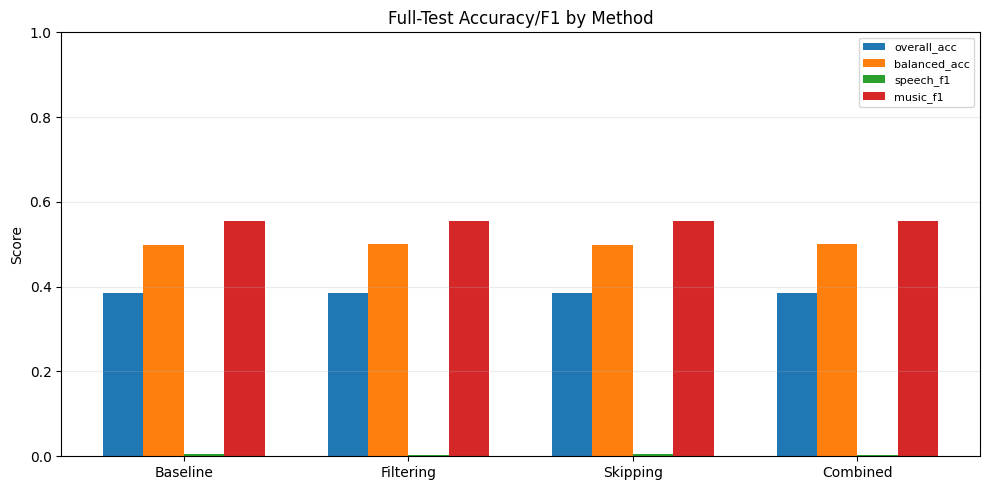

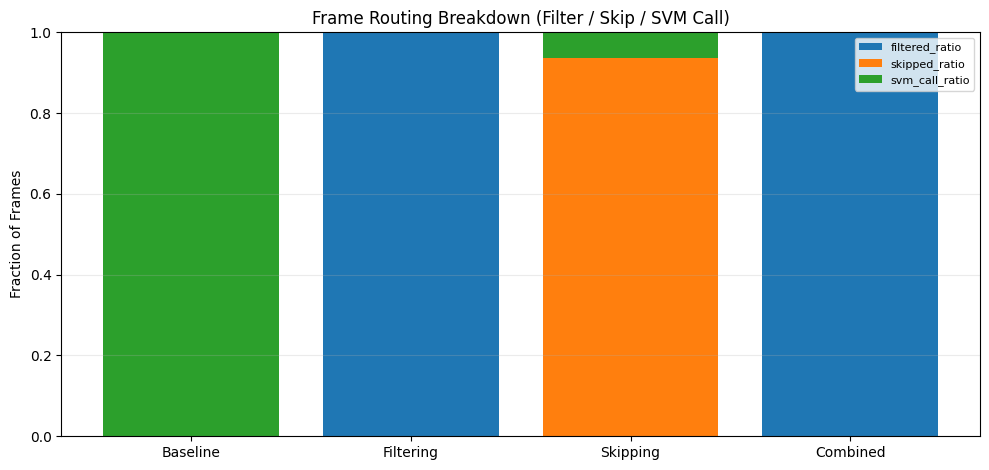

/tmp/ipykernel_13660/1246550513.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


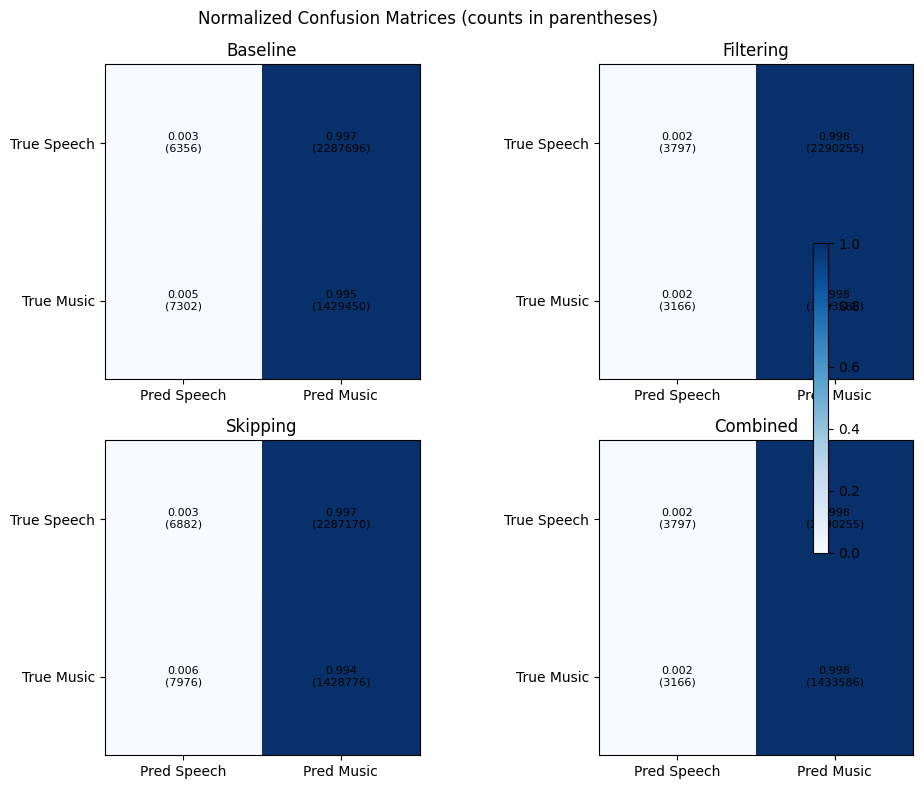

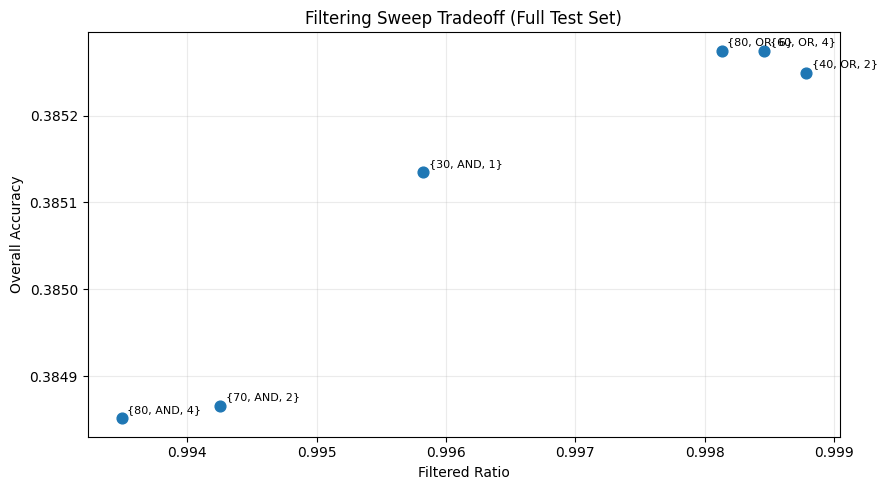

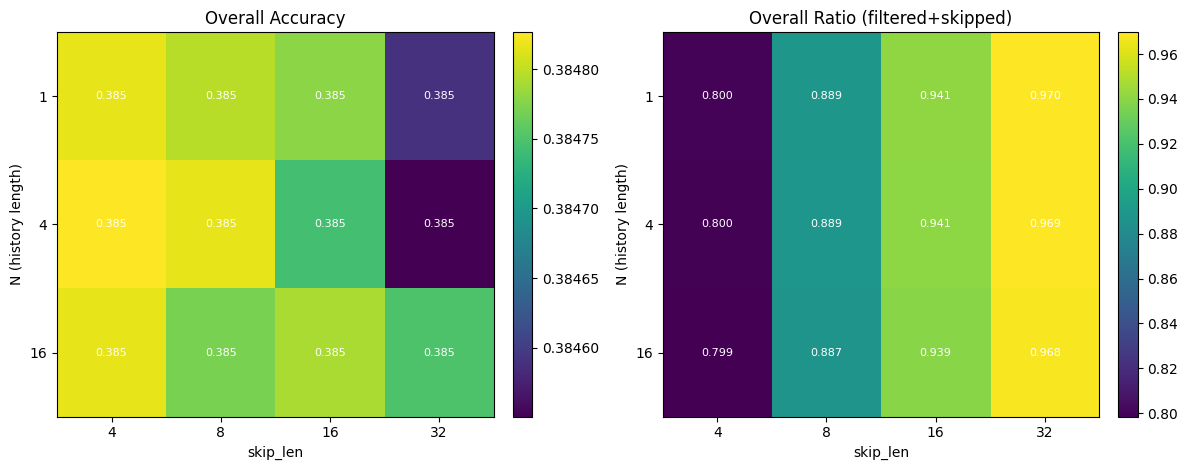

/tmp/ipykernel_13660/1246550513.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=method_order, showfliers=False)
/tmp/ipykernel_13660/1246550513.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=method_order, showfliers=False)


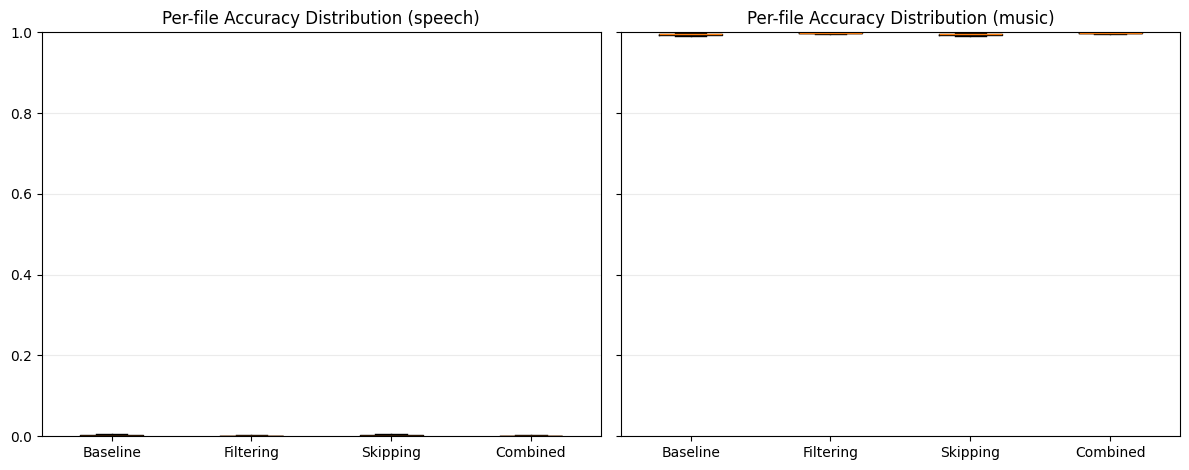

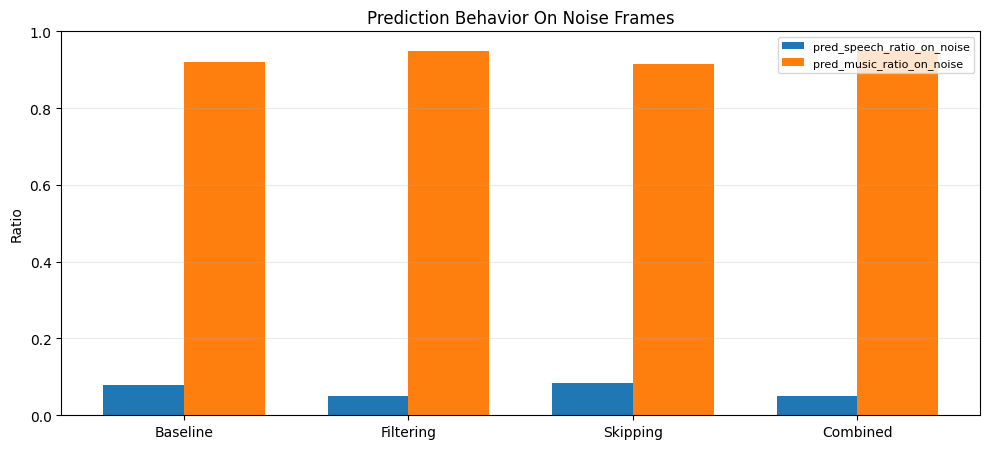

Figures rendered inline in this notebook (no file export).


In [46]:

import matplotlib.pyplot as plt
import numpy as np

method_order = [m for m in ['Baseline', 'Filtering', 'Skipping', 'Combined'] if m in set(summary_df['method'])]
sum_plot = summary_df.set_index('method').loc[method_order].reset_index()

# 1) Core accuracy/F1 comparison
fig, ax = plt.subplots(figsize=(10, 5))
metrics = ['overall_acc', 'balanced_acc', 'speech_f1', 'music_f1']
x = np.arange(len(method_order))
width = 0.18
for i, metric in enumerate(metrics):
    ax.bar(x + (i - 1.5) * width, sum_plot[metric].values, width=width, label=metric)
ax.set_xticks(x)
ax.set_xticklabels(method_order)
ax.set_ylim(0, 1.0)
ax.set_ylabel('Score')
ax.set_title('Full-Test Accuracy/F1 by Method')
ax.legend(loc='upper right', fontsize=8)
ax.grid(axis='y', alpha=0.25)
fig.tight_layout()
plt.show()

# 2) Compute-reduction composition
fig, ax = plt.subplots(figsize=(10, 4.8))
f = sum_plot['filtered_ratio'].values
s = sum_plot['skipped_ratio'].values
c = sum_plot['svm_call_ratio'].values
ax.bar(method_order, f, label='filtered_ratio')
ax.bar(method_order, s, bottom=f, label='skipped_ratio')
ax.bar(method_order, c, bottom=f + s, label='svm_call_ratio')
ax.set_ylim(0, 1.0)
ax.set_ylabel('Fraction of Frames')
ax.set_title('Frame Routing Breakdown (Filter / Skip / SVM Call)')
ax.legend(loc='upper right', fontsize=8)
ax.grid(axis='y', alpha=0.25)
fig.tight_layout()
plt.show()

# 3) Confusion matrices by method (row-normalized)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for ax, method in zip(axes, method_order):
    r = sum_plot[sum_plot['method'] == method].iloc[0]
    tp, fn, fp, tn = int(r.tp), int(r.fn), int(r.fp), int(r.tn)
    cm = np.array([[tp, fn], [fp, tn]], dtype=np.float64)
    cmn = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1.0)

    im = ax.imshow(cmn, vmin=0, vmax=1, cmap='Blues')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Pred Speech', 'Pred Music'])
    ax.set_yticklabels(['True Speech', 'True Music'])
    ax.set_title(method)

    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cmn[i, j]:.3f}\n({int(cm[i, j])})", ha='center', va='center', fontsize=8)

for k in range(len(method_order), 4):
    axes[k].axis('off')

fig.suptitle('Normalized Confusion Matrices (counts in parentheses)', y=0.98)
fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
fig.tight_layout()
plt.show()

# 4) Filtering sweep tradeoff
fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(filtering_sweep_df['filtered_ratio'], filtering_sweep_df['overall_acc'], s=60)
for _, row in filtering_sweep_df.iterrows():
    ax.annotate(row['triplet'], (row['filtered_ratio'], row['overall_acc']), xytext=(4, 4), textcoords='offset points', fontsize=8)
ax.set_xlabel('Filtered Ratio')
ax.set_ylabel('Overall Accuracy')
ax.set_title('Filtering Sweep Tradeoff (Full Test Set)')
ax.grid(alpha=0.25)
fig.tight_layout()
plt.show()

# 5) Skipping sweep heatmaps
pivot_acc = skipping_sweep_df.pivot(index='N', columns='skip_len', values='overall_acc').sort_index().sort_index(axis=1)
pivot_ratio = skipping_sweep_df.pivot(index='N', columns='skip_len', values='overall_ratio').sort_index().sort_index(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))
for ax, mat, title, fname in [
    (axes[0], pivot_acc, 'Overall Accuracy', '05a_skipping_heatmap_accuracy.png'),
    (axes[1], pivot_ratio, 'Overall Ratio (filtered+skipped)', '05b_skipping_heatmap_ratio.png')
]:
    im = ax.imshow(mat.values, aspect='auto', cmap='viridis')
    ax.set_xticks(range(len(mat.columns)))
    ax.set_xticklabels(mat.columns)
    ax.set_yticks(range(len(mat.index)))
    ax.set_yticklabels(mat.index)
    ax.set_xlabel('skip_len')
    ax.set_ylabel('N (history length)')
    ax.set_title(title)

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, f"{mat.values[i, j]:.3f}", ha='center', va='center', fontsize=8, color='white')

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()

# 6) Per-file accuracy distribution
per_file_all = []
for method, dfm in per_file_map.items():
    t = dfm[['label_name', 'file_acc']].copy()
    t = t[t['label_name'].isin(['speech', 'music'])]
    t['method'] = method
    per_file_all.append(t)
per_file_all = pd.concat(per_file_all, ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), sharey=True)
for ax, cls in zip(axes, ['speech', 'music']):
    d = per_file_all[per_file_all['label_name'] == cls]
    groups = [d[d['method'] == m]['file_acc'].values for m in method_order]
    ax.boxplot(groups, labels=method_order, showfliers=False)
    ax.set_title(f'Per-file Accuracy Distribution ({cls})')
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.25)

fig.tight_layout()
plt.show()

# 7) Noise behavior (if available)
if INCLUDE_NOISE_ANALYSIS and 'noise_analysis_df' in globals():
    fig, ax = plt.subplots(figsize=(10, 4.6))
    x = np.arange(len(noise_analysis_df))
    width = 0.36
    ax.bar(x - width/2, noise_analysis_df['pred_speech_ratio_on_noise'], width=width, label='pred_speech_ratio_on_noise')
    ax.bar(x + width/2, noise_analysis_df['pred_music_ratio_on_noise'], width=width, label='pred_music_ratio_on_noise')
    ax.set_xticks(x)
    ax.set_xticklabels(noise_analysis_df['method'])
    ax.set_ylim(0, 1.0)
    ax.set_ylabel('Ratio')
    ax.set_title('Prediction Behavior On Noise Frames')
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.25)
    fig.tight_layout()
    plt.show()

print('Figures rendered inline in this notebook (no file export).')


In [47]:
# Inline-only results view (no CSV/PNG export)
print('Inline-only mode: keeping all analysis in the notebook output.')

try:
    from IPython.display import display
except Exception:
    display = print

display(summary_df)
display(per_file_summary)
display(filtering_sweep_df)
display(skipping_sweep_df)

if INCLUDE_NOISE_ANALYSIS and 'noise_analysis_df' in globals():
    display(noise_analysis_df)


Inline-only mode: keeping all analysis in the notebook output.


,method,overall_acc,balanced_acc,speech_precision,speech_recall,speech_f1,music_precision,music_recall,music_f1,filtered_ratio,skipped_ratio,overall_ratio,svm_call_ratio,estimated_time_ms_per_frame,tp,tn,fp,fn,total_frames_eval
1,Filtering,0.385274,0.499726,0.545311,0.001655,0.003300,0.384975,0.997796,0.555590,0.998134,0.000000,0.998134,0.001866,0.000020,3797,1433586,3166,2290255,3730804
3,Combined,0.385274,0.499726,0.545311,0.001655,0.003300,0.384975,0.997796,0.555590,0.998134,0.001738,0.999871,0.000129,0.000001,3797,1433586,3166,2290255,3730804
0,Baseline,0.384852,0.498844,0.465368,0.002771,0.005508,0.384556,0.994918,0.554706,0.000000,0.000000,0.000000,1.000000,0.010921,6356,1429450,7302,2287696,3730804
2,Skipping,0.384812,0.498724,0.463185,0.003000,0.005961,0.384499,0.994449,0.554574,0.000000,0.937477,0.937477,0.062523,0.000683,6882,1428776,7976,2287170,3730804


,method,class,files,mean_file_acc,std_file_acc,min_file_acc,max_file_acc,mean_filtered_ratio_file,mean_skipped_ratio_file
1,Baseline,music,132,0.993828,0.006932,0.929850,0.998748,0.000000,0.000000
0,Baseline,speech,86,0.003845,0.006685,0.001034,0.039674,0.000000,0.000000
7,Combined,music,132,0.997197,0.005975,0.939243,0.999542,0.997197,0.002604
6,Combined,speech,86,0.002173,0.004659,0.000315,0.024945,0.997827,0.002027
3,Filtering,music,132,0.997197,0.005975,0.939243,0.999542,0.997197,0.000000
2,Filtering,speech,86,0.002173,0.004659,0.000315,0.024945,0.997827,0.000000
5,Skipping,music,132,0.993270,0.007039,0.929557,0.998535,0.000000,0.937453
4,Skipping,speech,86,0.004220,0.007349,0.001079,0.048830,0.000000,0.937475


,triplet,overall_acc,speech_recall,music_recall,speech_f1,music_f1,filtered_ratio,svm_call_ratio,estimated_time_ms_per_frame
4,"{40, OR, 2}",0.385249,0.001106,0.998609,0.002207,0.555781,0.998784,0.001216,0.000013
3,"{60, OR, 4}",0.385275,0.001389,0.998222,0.002771,0.555695,0.998461,0.001539,0.000017
2,"{80, OR, 6}",0.385274,0.001655,0.997796,0.003300,0.555590,0.998134,0.001866,0.000020
5,"{30, AND, 1}",0.385135,0.002096,0.996729,0.004175,0.555269,0.995823,0.004177,0.000046
1,"{70, AND, 2}",0.384866,0.002768,0.994958,0.005504,0.554722,0.994255,0.005745,0.000063
0,"{80, AND, 4}",0.384852,0.002771,0.994918,0.005508,0.554706,0.993493,0.006507,0.000071


,skip_len,N,overall_acc,speech_recall,music_recall,overall_ratio,svm_call_ratio,estimated_time_ms_per_frame
1,4,4,0.384826,0.002850,0.994726,0.799683,0.200317,0.002188
4,8,4,0.384816,0.002924,0.994579,0.888537,0.111463,0.001217
0,4,1,0.384816,0.002827,0.994734,0.799978,0.200022,0.002184
2,4,16,0.384816,0.002827,0.994734,0.798509,0.201491,0.002200
3,8,1,0.384797,0.002907,0.994559,0.888864,0.111136,0.001214
8,16,16,0.384792,0.003017,0.994369,0.939424,0.060576,0.000662
6,16,1,0.384779,0.003058,0.994270,0.941150,0.058850,0.000643
5,8,16,0.384771,0.002859,0.994569,0.887233,0.112767,0.001232
11,32,16,0.384749,0.003057,0.994193,0.967893,0.032107,0.000351
7,16,4,0.384744,0.003127,0.994070,0.940802,0.059198,0.000646


,method,noise_frames,pred_speech_ratio_on_noise,pred_music_ratio_on_noise
0,Baseline,1120322,0.079680,0.920320
1,Filtering,1120322,0.050356,0.949644
2,Skipping,1120322,0.084383,0.915617
3,Combined,1120322,0.050236,0.949764
